## Observations and Insights 

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_study_df = pd.merge(study_results, mouse_metadata, on="Mouse ID")

In [3]:
#### DONE - Checking the number of mice in the DataFrame.

num_mice_ID_df = pd.DataFrame({'Number of mice in study':[mouse_study_df['Mouse ID'].nunique()]})
num_mice_ID_df.style.hide_index()


Number of mice in study
249


In [4]:
#### DONE - Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 

#Make a new field mouse_tp which combines Mouse_ID + Timepoint. This should be unique since the same mouse can only be observed once at a particular timepoint. If not unique, something is wrong with mouse's data so remove all records for that mouse.
mouse_study_df['mouse_tp'] = mouse_study_df['Mouse ID'] + mouse_study_df['Timepoint'].astype(str)

#Creates table of True (is a duplicate mouse_tp ID) or False (is not a duplicate mouse_tp ID)
duplicate_mouse_tp = pd.DataFrame(mouse_study_df['mouse_tp'].value_counts()>1)

#Change column name to be descriptive of what True/False indicates in this column
duplicate_mouse_tp.rename(columns = {'mouse_tp':'duplicate_mouse'}, inplace = True)

#Extract the Mouse ID from the mouse_tp and set the index to Mouse ID
duplicate_mouse_tp['Mouse ID']= duplicate_mouse_tp.index.str[:4]
duplicate_mouse_tp.set_index('Mouse ID', inplace=True)

#Remove all the rows with duplicate ID. Result is a table of unique Mouse ID's and whether each ID is duplicated and needs to be removed (TRUE) or not duplicated and shoudl be kept (FALSE)
index = duplicate_mouse_tp.index
is_duplicate = index.duplicated(keep="first")
not_duplicate = ~is_duplicate
dup_mouse_truth = duplicate_mouse_tp[not_duplicate]

#Show duplicate Mouse ID's which should be removed
dup_IDs = dup_mouse_truth.loc[dup_mouse_truth['duplicate_mouse']]

dup_IDs

,duplicate_mouse
Mouse ID,
g989,True


In [5]:
#### DONE - Optional: Get all the data for the duplicate mouse ID. 

#Add duplicate column (TRUE) to full mouse study database
mouse_study_dup_flag_df = pd.merge(mouse_study_df, dup_mouse_truth, on='Mouse ID')

#Show records for duplicate Mouse ID's
dup_mice_df = mouse_study_dup_flag_df.loc[mouse_study_dup_flag_df['duplicate_mouse']]
dup_mice_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g),mouse_tp,duplicate_mouse
860,g989,0,45.000000,0,Propriva,Female,21,26,g9890,True
861,g989,0,45.000000,0,Propriva,Female,21,26,g9890,True
862,g989,5,48.786801,0,Propriva,Female,21,26,g9895,True
863,g989,5,47.570392,0,Propriva,Female,21,26,g9895,True
864,g989,10,51.745156,0,Propriva,Female,21,26,g98910,True
865,g989,10,49.880528,0,Propriva,Female,21,26,g98910,True
866,g989,15,51.325852,1,Propriva,Female,21,26,g98915,True
867,g989,15,53.442020,0,Propriva,Female,21,26,g98915,True
868,g989,20,55.326122,1,Propriva,Female,21,26,g98920,True
869,g989,20,54.657650,1,Propriva,Female,21,26,g98920,True


In [6]:
#### DONE - Create a clean DataFrame by dropping the duplicate mouse by its ID.

#Make new mouse study df with duplicate mouse ID's removed. Clean up by deleting the working columns added during these steps.
no_dups_mouse_study_df = mouse_study_dup_flag_df.loc[mouse_study_dup_flag_df['duplicate_mouse']==False]
no_dups_mouse_study_df.drop(['mouse_tp', 'duplicate_mouse'], axis=1, inplace=True)

no_dups_mouse_study_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22
...,...,...,...,...,...,...,...,...
1888,m601,25,33.118756,1,Capomulin,Male,22,17
1889,m601,30,31.758275,1,Capomulin,Male,22,17
1890,m601,35,30.834357,1,Capomulin,Male,22,17
1891,m601,40,31.378045,1,Capomulin,Male,22,17


In [7]:
#### DONE - Checking the number of mice in the clean DataFrame.

no_dup_num_mice_ID = pd.DataFrame({'Number mice after removing duplicates':[no_dups_mouse_study_df['Mouse ID'].nunique()]})
no_dup_num_mice_ID.style.hide_index()


Number mice after removing duplicates
248


## Summary Statistics

In [8]:
#### DONE - Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

#### This method is the most straighforward, creating multiple series and putting them all together at the end.
#List of drug regimens
drug_regimens = no_dups_mouse_study_df['Drug Regimen'].unique()

#For each drug regimen calculate mean and make list of means
drug_reg_means = [no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==x, 'Tumor Volume (mm3)'].mean() for x in drug_regimens]

#For each drug regimen calculate median and make list of medians
drug_reg_medians = [no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==x, 'Tumor Volume (mm3)'].median() for x in drug_regimens]

#For each drug regimen calculate variance and make list of variances
drug_reg_vars = [no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==x, 'Tumor Volume (mm3)'].var() for x in drug_regimens]

#For each drug regimen calculate standard deviation and make list of standard deviations
drug_reg_stds = [no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==x, 'Tumor Volume (mm3)'].std() for x in drug_regimens]

#For each drug regimen calculate standard erro and make list of standard errors
drug_reg_sems = [no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==x, 'Tumor Volume (mm3)'].sem() for x in drug_regimens]

#Create final summary stats table by zipping all the lists and naming the columns. Set Drug Regimen as index
drug_reg_summary_stats = pd.DataFrame(list(zip(drug_regimens, drug_reg_means, drug_reg_medians, drug_reg_vars, drug_reg_stds, drug_reg_sems)), columns= ['Drug Regimen', 'Tumor Volume mean', 'Tumor Volume median', 'Tumor Volume variance', 'Tumor Volume std dev', 'Tumor Volume SEM'])
drug_reg_summary_stats.set_index('Drug Regimen', inplace=True)

drug_reg_summary_stats

,Tumor Volume mean,Tumor Volume median,Tumor Volume variance,Tumor Volume std dev,Tumor Volume SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Zoniferol,53.236507,51.818479,48.533355,6.966589,0.516398
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331


## Bar Plots

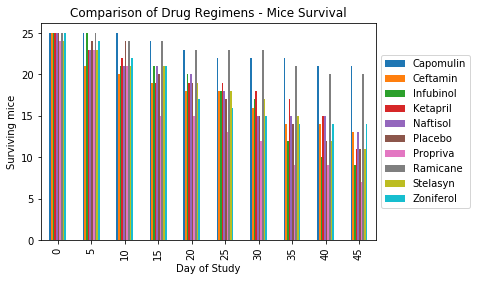

In [9]:
#### DONE - Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pandas. 


#Plot a bar chart using Pandas plot.bar method. Group by Timepoints and then count the Drug Regimen occurences which indicates a live mouse under that Drug Regimen. Unstack creates a pivot table type structure.
no_dups_mouse_study_df.groupby('Timepoint')['Drug Regimen'].value_counts().unstack().plot(kind='bar')

#Set labels, titles, legend
plt.ylabel('Surviving mice')
plt.xlabel('Day of Study')
plt.title('Comparison of Drug Regimens - Mice Survival')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

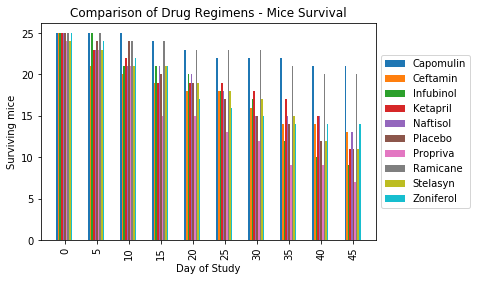

In [10]:
#### DONE - Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pyplot.

#Group by Timepoints and then count the Drug Regimen occurences which indicates a live mouse under that Drug Regimen. Unstack creates a pivot table type structure.
mouse_plot = no_dups_mouse_study_df.groupby('Timepoint')['Drug Regimen'].value_counts().unstack()

#Capture the number of Drug Regimens for the plot looping
num_DR = np.arange(len(mouse_plot.columns))

#set x axis labels, location, and legend values
xtick_labels = mouse_plot.index
xtick_loc = num_DR
legend_values = mouse_plot.columns

# set width of a bar in the bar chart
barWidth = 0.05
 
#Plot bar chart using pyplot.bar method. Shift the bar by barwidth to make Drug Regimen groupings visually
for i in num_DR:
     plt.bar((num_DR-len(num_DR)*barWidth/2)+barWidth*i, mouse_plot.iloc[:,i], width=barWidth)

#Set labels, title, legend
plt.xticks(xtick_loc, xtick_labels, rotation=90)
plt.ylabel('Surviving mice')
plt.xlabel('Day of Study')
plt.title('Comparison of Drug Regimens - Mice Survival')
plt.legend(legend_values,loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


## Pie Plots

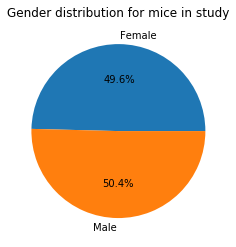

In [11]:
#### DONE - Generate a pie plot showing the distribution of female versus male mice using pandas

#Get mice from original mouse database, discard the duplicate mice
mouse_gender_df = mouse_metadata.loc[~mouse_metadata['Mouse ID'].isin(dup_IDs.index)]

#Group by gender and get count
mouse_gender_df_grp = mouse_gender_df.groupby('Sex')
gender_count = mouse_gender_df_grp['Mouse ID'].count()

# #Plot pie chart using Pandas .plot functionality
gender_count.plot(kind='pie', y='Sex', legend='', autopct='%1.1f%%', title='Gender distribution for mice in study')
plt.ylabel('')
plt.show()



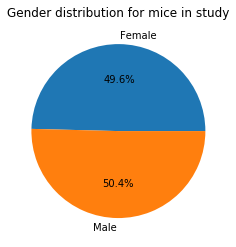

In [12]:
#### DONE - Generate a pie plot showing the distribution of female versus male mice using pyplot

#Pie plot of gender using pyplot
plt.pie(gender_count, labels=gender_count.index, autopct='%1.1f%%')
plt.ylabel=(["Female", "Male"])
plt.title('Gender distribution for mice in study')
plt.show()


## Quartiles, Outliers and Boxplots

In [13]:
#### DONE - Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. Calculate the IQR and quantitatively determine if there are any potential outliers.  

#Group mice ID and sort descending by timepoint within Mouse ID. Grab first row for each ID. This gives a df with one row for each mouse that contains the final timepoint and tumor volume
Last_tp_by_Mouse_ID = pd.DataFrame(no_dups_mouse_study_df.sort_values(['Mouse ID','Timepoint'],ascending=False).groupby('Mouse ID').first())

#Group by Drug Regimen. Use describe to get stats and save as df
Final_tp_by_DR = Last_tp_by_Mouse_ID.groupby('Drug Regimen')
Final_TV_size_stats = pd.DataFrame(Final_tp_by_DR['Tumor Volume (mm3)'].describe())

#Calculate IQR, upper and lower bound for outlier identifcation, identify outliers
Final_TV_size_stats['IQR']= Final_TV_size_stats['75%']-Final_TV_size_stats['25%']
Final_TV_size_stats['Outlier_Upper']= Final_TV_size_stats['75%']+Final_TV_size_stats['IQR']*1.5
Final_TV_size_stats['Outlier_Lower']= Final_TV_size_stats['25%']-Final_TV_size_stats['IQR']*1.5

#Flag Outlier as TRUE if min or max are outside the the IQR lower or upper limits
Final_TV_size_stats['Outlier'] = (Final_TV_size_stats['min']<Final_TV_size_stats['Outlier_Lower']) | (Final_TV_size_stats['max']>Final_TV_size_stats['Outlier_Upper'])

Final_TV_size_stats

,count,mean,std,min,25%,50%,75%,max,IQR,Outlier_Upper,Outlier_Lower,Outlier
Drug Regimen,,,,,,,,,,,,
Capomulin,25.0,36.667568,5.715188,23.343598,32.377357,38.125164,40.159220,47.685963,7.781863,51.832015,20.704562,False
Ceftamin,25.0,57.753977,8.365568,45.000000,48.722078,59.851956,64.299830,68.923185,15.577752,87.666458,25.355450,False
Infubinol,25.0,58.178246,8.602957,36.321346,54.048608,60.165180,65.525743,72.226731,11.477135,82.741446,36.832905,True
Ketapril,25.0,62.806191,9.945920,45.000000,56.720095,64.487812,69.872251,78.567014,13.152155,89.600484,36.991862,False
Naftisol,25.0,61.205757,10.297083,45.000000,52.079510,63.283288,69.563621,76.668817,17.484111,95.789787,25.853344,False
Placebo,25.0,60.508414,8.874672,45.000000,52.942902,62.030594,68.134288,73.212939,15.191386,90.921368,30.155822,False
Propriva,24.0,56.493884,8.415626,45.000000,49.119739,55.591622,62.689368,72.455421,13.569629,83.043811,28.765296,False
Ramicane,25.0,36.191390,5.671539,22.050126,31.560470,36.561652,40.659006,45.220869,9.098537,54.306811,17.912664,False
Stelasyn,24.0,61.001707,9.504293,45.000000,52.476596,62.192350,69.103944,75.123690,16.627349,94.044968,27.535572,False


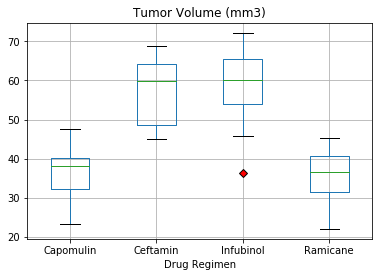

In [14]:
#### DONE - Generate a box plot of the final tumor volume of each mouse across four regimens of interest
#Capomulin, Ramicane, Infubinol, and Ceftamin
#Note the instructions say to evaluate the above regimens as the most promising. Based on the statistics I don't see Ceftamin as promising since the tumor did not shrink at all from the starting value of 45 mm3. Propriva has a sligtly smaller average tumor size, but also is not effective. 

#List of the top 4 treatments
Top4_DR =['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

#Change the marker and color of any outliers
red_diamond = dict(markerfacecolor='r', marker='D')

#Make a table of the Tumor Volume at the last timepoint for each mouse that's in the top 4 Drug Regimens
Final_TV_for_top4_DR =Last_tp_by_Mouse_ID.loc[Last_tp_by_Mouse_ID['Drug Regimen'].isin(Top4_DR)]

#Create a boxplot for the final Tumor Volumes under the top 4 DR's. Outlier is a red diamond
Final_TV_for_top4_DR.boxplot(by='Drug Regimen', column='Tumor Volume (mm3)', flierprops=red_diamond)
plt.suptitle('')
plt.show()

## Line and Scatter Plots

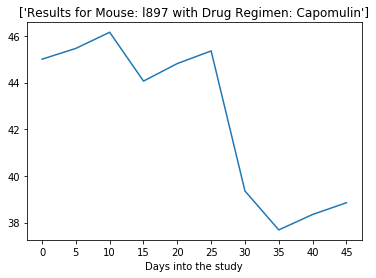

In [15]:
#### Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
#Start with the clean no duplictes mouse df.
mouse_metadata_no_dups = mouse_metadata.loc[mouse_metadata['Mouse ID'].isin(no_dups_mouse_study_df['Mouse ID'])]

#Input for which Drug Regimen to plot
which_regimen_plot = 'Capomulin'

#Create a list of all the mice IDs that were in the target Drug Regimen
regimen_mouse_IDs = pd.Series(mouse_metadata_no_dups['Mouse ID'].loc[mouse_metadata_no_dups['Drug Regimen']==which_regimen_plot])

#Generate a random list of ID's to be plotted
how_many_mice_plot = 1
IDs_to_plot = np.random.choice(regimen_mouse_IDs, how_many_mice_plot)

#Select just the mice in the desired Drug Regimen
plot_mice = no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==which_regimen_plot]
#Select just the ID, Timepoint, and Tumor Volume columns that will be needed to do the plot
plot_mice = plot_mice[['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)']]
#Select just the mice with the random ID generated
plot_mice = plot_mice.loc[plot_mice['Mouse ID'].isin(IDs_to_plot)]

#For the selected mouse at each timepoint plot the tumor volume. 
plt.plot(plot_mice['Timepoint'], plot_mice['Tumor Volume (mm3)'])
plt.xticks(np.arange(0,50,5))
plt.xlabel('Days into the study')
#plt.ylabel('Tumor Volume (mm3)')
plt.title('Results for Mouse: '+IDs_to_plot+' with Drug Regimen: '+which_regimen_plot)
plt.show()

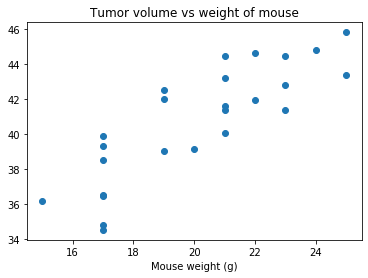

In [16]:
#### Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
scatter_plot_mice = no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==which_regimen_plot]
scatter_plot_mice = scatter_plot_mice.groupby('Mouse ID')

plt.scatter(scatter_plot_mice['Weight (g)'].mean(), scatter_plot_mice['Tumor Volume (mm3)'].mean())
plt.xlabel('Mouse weight (g)')
#plt.ylabel('Tumor volume (mm3)')
plt.title('Tumor volume vs weight of mouse')
plt.show()

## Correlation and Regression

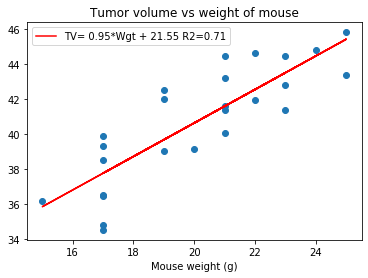

In [19]:
#### Calculate the correlation coefficient and linear regression model 
#### for mouse weight and average tumor volume for the Capomulin regimen

slope, intercept, r_value, p_value, std_err = st.linregress(scatter_plot_mice['Weight (g)'].mean(), scatter_plot_mice['Tumor Volume (mm3)'].mean())
r_squared = r_value**2

plt.scatter(scatter_plot_mice['Weight (g)'].mean(), scatter_plot_mice['Tumor Volume (mm3)'].mean())
plt.plot(scatter_plot_mice['Weight (g)'].mean(), scatter_plot_mice['Weight (g)'].mean()*slope+intercept, color='red', label= 'TV= '+str(round(slope,2))+'*Wgt + '+str(round(intercept,2))+' R2='+str(round(r_squared,2))) 
plt.xlabel('Mouse weight (g)')
#plt.ylabel('Tumor volume (mm3)')
plt.title('Tumor volume vs weight of mouse')
plt.legend()
plt.show()